###Install necessary library

In [1]:
!pip install contractions
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import csv
import regex as re
import nltk
import string
import itertools
import tqdm
import unicodedata
import contractions
from nltk.tokenize import word_tokenize
import spacy
import random
import keras
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.9 MB/s eta 0:00:00


### Importing dataset for analysis

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Load the dataset from Google Drive
Financial_data = pd.read_csv('/content/drive/MyDrive/NLP Project Dataset/all-data.csv', encoding='latin-1', header=None)


In [ ]:
# Define column names
column_names = ['Sentiment', 'Sentences']

# Rename the columns in the loaded DataFrame
Financial_data.columns = column_names

# Display DataFrame information
Financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Sentences  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [ ]:
# Displaying basic information about the DataFrame structure
Financial_data.head()

,Sentiment,Sentences
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


###Text Preprocessing

In [ ]:
from bs4 import BeautifulSoup
# Remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    clean_text = soup.get_text()
    clean_text = re.sub(r'[\r|\n|\r\n]+', '\n', clean_text)
    return clean_text

# Remove accented characters from text
def remove_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Remove stopwords from a list of words
def remove_stopwords(words):
    stopwords_list = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in stopwords_list]


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

# Preprocess a corpus of documents
def preprocess_corpus(docs):
  normaldocs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = remove_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_characters(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = remove_stopwords(doc)
    normaldocs.append(doc)

  normaldocs = [" ".join(word) for word in normaldocs]
  return normaldocs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
Financial_data.Sentences = preprocess_corpus(Financial_data.Sentences)

100%|██████████| 4846/4846 [00:03<00:00, 1386.84it/s]


In [ ]:
# Display the first few rows of the Financial_data DataFrame after text preprocessing
Financial_data.head(10)

,Sentiment,Sentences
0,neutral,according gran company plans move production r...
1,neutral,technopolis plans develop stages area less 100...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy years 20092...
5,positive,financing aspocomp growth aspocomp aggressivel...
6,positive,last quarter 2010 componenta net sales doubled...
7,positive,third quarter 2010 net sales increased 52 eur ...
8,positive,operating profit rose eur 131 mn eur 87 mn cor...
9,positive,operating profit totalled eur 211 mn eur 186 m...


In [ ]:
from sklearn.utils import resample

# Separate positive and negative sentiment classes in training data for upsampling
positive_sentiment = Financial_data[Financial_data['Sentiment'] == "positive"]
negative_sentiment = Financial_data[Financial_data['Sentiment'] == "negative"]

print("Positive class before upsampling:", positive_sentiment.shape)
print("Negative class before upsampling:", negative_sentiment.shape)

# Upsample negative sentiment class
negative_sentiment_upsampled = resample(negative_sentiment,
                                        replace=True,                    # sample with replacement
                                        n_samples=positive_sentiment.shape[0],  # match the majority class
                                        random_state=123)               # for reproducible results

# Combine positive class with upsampled negative class
balanced_Financial_data = pd.concat([positive_sentiment, negative_sentiment_upsampled])

# Display new class counts after upsampling
print("After upsampling\n", balanced_Financial_data.Sentiment.value_counts(), sep="")


Positive class before upsampling: (1363, 2)
Negative class before upsampling: (604, 2)
After upsampling
Sentiment
positive    1363
negative    1363
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_Financial_data.Sentences, balanced_Financial_data.Sentiment, test_size=0.3, random_state=42)

# Print shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (1908,), X_test shape: (818,), y_train shape: (1908,), y_test shape: (818,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
#Tokenization
token = Tokenizer()
token.fit_on_texts(X_train)
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))


Vocabulary size=5015
Number of Documents=1908


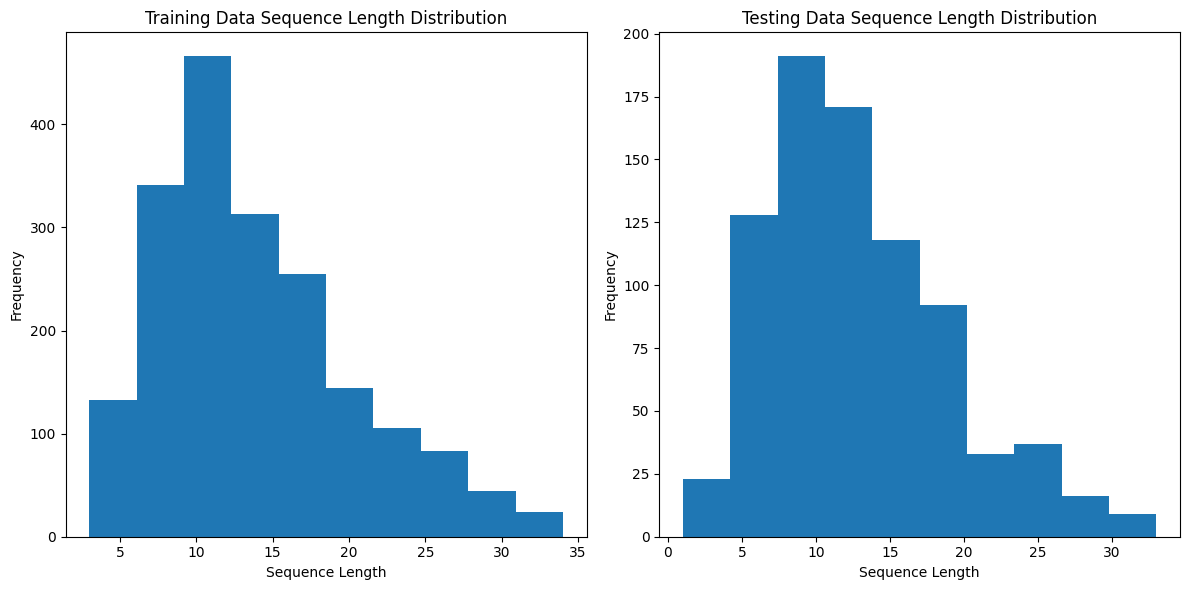

In [ ]:
import matplotlib.pyplot as plt

# code for tokenization and sequence length collection
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

# Create histograms for sequence lengths in training and testing data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# Set x and y labels and titles for the first subplot (training data)
ax[0].set_xlabel('Sequence Length')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Training Data Sequence Length Distribution')

# Set x and y labels and titles for the second subplot (testing data)
ax[1].set_xlabel('Sequence Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Testing Data Sequence Length Distribution')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#padding
MAX_SEQUENCE_LENGTH = 30
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((1908, 30), (818, 30))

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report


# Convert padded sequences into text
X_train_text = [" ".join(map(str, sentence)) for sentence in X_train]
X_test_text = [" ".join(map(str, sentence)) for sentence in X_test]

# Convert text data into numerical vectors using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_count = vectorizer.fit_transform(X_train_text)
X_test_count = vectorizer.transform(X_test_text)

# Train Naive Bayes classifier
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_count, y_train)

# Predict on the test set
predictions_nb = naive_bayes.predict(X_test_count)

# Evaluate the classifier
accuracy_nb = accuracy_score(y_test, predictions_nb)
report_nb = classification_report(y_test, predictions_nb)

print("Naive Bayes Accuracy:", accuracy_nb)
print("Naive Bayes Classification Report:")
print(report_nb)


Naive Bayes Accuracy: 0.8740831295843521
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.79      0.87       418

    accuracy                           0.87       818
   macro avg       0.88      0.88      0.87       818
weighted avg       0.89      0.87      0.87       818



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert padded sequences into text
X_train_text = [" ".join(map(str, sentence)) for sentence in X_train]
X_test_text = [" ".join(map(str, sentence)) for sentence in X_test]

# Convert text data into numerical vectors using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_count = vectorizer.fit_transform(X_train_text)
X_test_count = vectorizer.transform(X_test_text)

# Train Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters as needed
random_forest.fit(X_train_count, y_train)

# Predict on the test set
predictions_rf = random_forest.predict(X_test_count)

# Evaluate the classifier
accuracy_rf = accuracy_score(y_test, predictions_rf)
report_rf = classification_report(y_test, predictions_rf)

accuracy_rf=accuracy_rf*100
print(f'Accuracy: {accuracy_rf:.2f}%')
print("Random Forest Classification Report:")
print(report_rf)


Accuracy: 92.18%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       400
           1       0.93      0.92      0.92       418

    accuracy                           0.92       818
   macro avg       0.92      0.92      0.92       818
weighted avg       0.92      0.92      0.92       818



In [ ]:
# CNN model
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

embedding_size = 300
model = Sequential()
model.add(Embedding(vocab, embedding_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(64,8, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           1504800   
                                                                 
 conv1d (Conv1D)             (None, 23, 64)            153664    
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 64)            0         
                                                                 
 dense (Dense)               (None, 11, 8)             520       
                                                                 
 dropout_1 (Dropout)         (None, 11, 8)             0         
                                                        

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 100
batch_size = 4

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
430/430 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.9948
Epoch 1: val_accuracy improved from -inf to 0.87958, saving model to ./best_model/best_model_cnn1d.h5
430/430 [==============================] - 20s 47ms/step - loss: 0.2456 - accuracy: 0.9948 - val_loss: 0.5417 - val_accuracy: 0.8796
Epoch 2/100
430/430 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9942
Epoch 2: val_accuracy improved from 0.87958 to 0.88482, saving model to ./best_model/best_model_cnn1d.h5
430/430 [==============================] - 19s 44ms/step - loss: 0.2388 - accuracy: 0.9942 - val_loss: 0.5291 - val_accuracy: 0.8848
Epoch 3/100
429/430 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9942
Epoch 3: val_accuracy improved from 0.88482 to 0.89005, saving model to ./best_model/best_model_cnn1d.h5
430/430 [==============================] - 17s 40ms/step - loss: 0.2321 - accuracy: 0.9942 - val_loss: 0.5362 - val_accuracy: 0.890

In [ ]:
from keras.models import load_model

saved_model = load_model('./best_model/best_model_cnn1d.h5')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
# Assuming train_acc and test_acc are tuples/lists containing accuracy values
train_accuracy = train_acc[1] * 100
test_accuracy = test_acc[1] * 100

print(f'Train Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')


26/26 [==============================] - 0s 13ms/step - loss: 0.3906 - accuracy: 0.9156
Train Accuracy: 98.43%
Test Accuracy: 91.56%


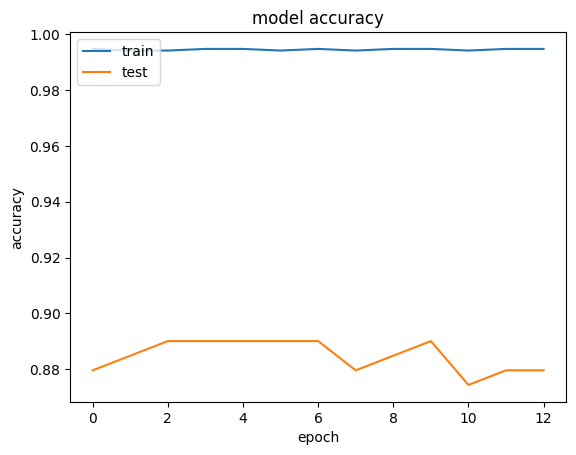

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

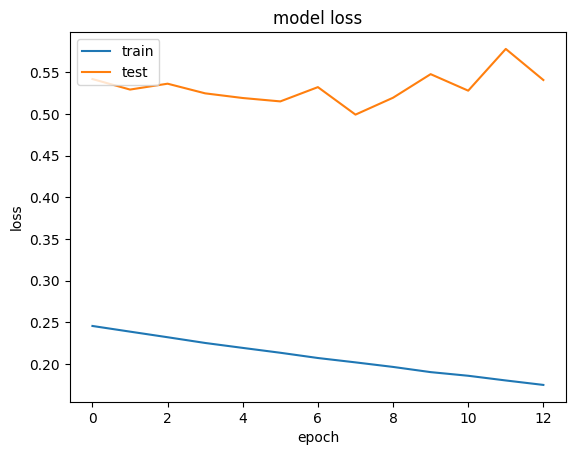

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#check
def predictions(saved_model, x):
    prediction_probs = saved_model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions


In [ ]:

#trained CNN model, X_test is test data, and y_test contains the corresponding true labels. calculates evaluation metrics like accuracy, precision, recall, and F1-score using these predictions on the test set.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
predictions_test = predictions(saved_model,X_test)

labels = ['positive', 'negative']
print("CNN 1D Accuracy: %.2f%%" % (accuracy_score(y_test, predictions_test)*100))
print("CNN 1D Precision: %.2f%%" % (precision_score(y_test, predictions_test, average="macro")*100))
print("CNN 1D Recall: %.2f%%" % (recall_score(y_test, predictions_test, average="macro")*100))
print("CNN 1D f1_score: %.2f%%" % (f1_score(y_test, predictions_test, average="macro")*100))
print('================================================\n')
print(classification_report(y_test, predictions_test))
pd.DataFrame(confusion_matrix(y_test, predictions_test), index=labels, columns=labels)

26/26 [==============================] - 1s 12ms/step
CNN 1D Accuracy: 91.56%
CNN 1D Precision: 91.58%
CNN 1D Recall: 91.55%
CNN 1D f1_score: 91.56%

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       400
           1       0.91      0.92      0.92       418

    accuracy                           0.92       818
   macro avg       0.92      0.92      0.92       818
weighted avg       0.92      0.92      0.92       818



,positive,negative
positive,363,37
negative,32,386


In [ ]:
# RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, SpatialDropout1D, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score

vocab_size = len(token.word_index) + 1
embedding_size = 300
max_sequence_length = 30

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_sequence_length))
model_rnn.add(SpatialDropout1D(0.2))
model_rnn.add(SimpleRNN(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_rnn.add(GlobalMaxPooling1D())
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           1504800   
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 300)           0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 30, 128)           54912     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100
batch_size = 32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_rnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_rnn = model_rnn.fit(X_train, y_train, batch_size=batch_size, shuffle=True, validation_split=0.1,
                             epochs=epochs, verbose=1, callbacks=[es, mc])


Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5824
Epoch 1: val_accuracy improved from -inf to 0.81675, saving model to ./best_model/best_model_rnn.h5
54/54 [==============================] - 8s 80ms/step - loss: 0.6819 - accuracy: 0.5824 - val_loss: 0.6321 - val_accuracy: 0.8168
Epoch 2/100
53/54 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.8449
Epoch 2: val_accuracy improved from 0.81675 to 0.91623, saving model to ./best_model/best_model_rnn.h5
54/54 [==============================] - 3s 61ms/step - loss: 0.4511 - accuracy: 0.8439 - val_loss: 0.2935 - val_accuracy: 0.9162
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9534
Epoch 3: val_accuracy did not improve from 0.91623
54/54 [==============================] - 5s 85ms/step - loss: 0.1187 - accuracy: 0.9534 - val_loss: 0.2476 - val_accuracy: 0.8901
Epoch 4/100
53/54 [============================>.] - ETA: 0s - loss: 0.

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved RNN model
saved_rnn_model = load_model('./best_model/best_model_rnn.h5')

# Evaluate the RNN model on the training and test sets
train_acc_rnn = saved_rnn_model.evaluate(X_train, y_train, verbose=1)
test_acc_rnn = saved_rnn_model.evaluate(X_test, y_test, verbose=1)

train_accuracyrnn = train_acc_rnn[1] * 100
test_accuracyrnn = test_acc_rnn[1] * 100

print(f'Train Accuracy: {train_accuracyrnn:.2f}%')
print(f'Test Accuracy: {test_accuracyrnn:.2f}%')



26/26 [==============================] - 0s 16ms/step - loss: 0.2653 - accuracy: 0.8924
Train Accuracy: 95.86%
Test Accuracy: 89.24%


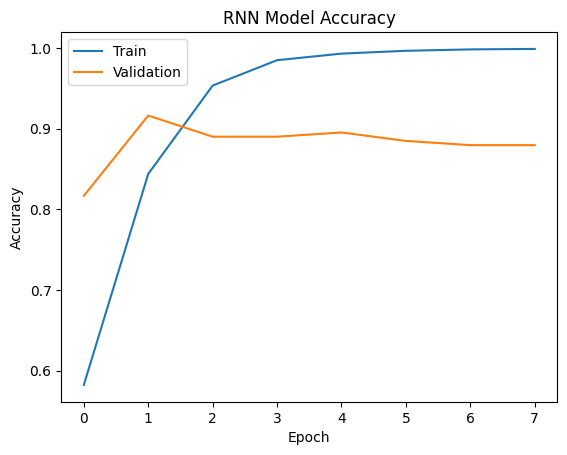

In [ ]:


# Visualize the model accuracy history for RNN
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


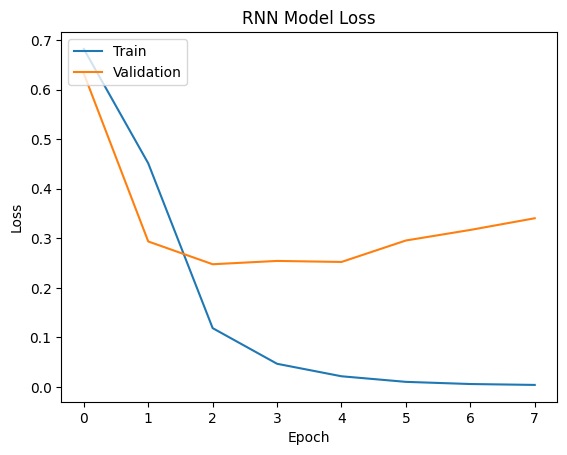

In [ ]:
# Visualize the model loss history for RNN
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Function to make predictions using the RNN model
def rnn_predictions(saved_rnn_model, x):
    prediction_probs = saved_rnn_model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

labels = ['positive', 'negative']

# Get predictions using the RNN model
rnn_preds = rnn_predictions(saved_rnn_model, X_test)

print("RNN Accuracy: %.2f%%" % (accuracy_score(y_test, rnn_preds)*100))
print("RNN Precision: %.2f%%" % (precision_score(y_test, rnn_preds, average="macro")*100))
print("RNN Recall: %.2f%%" % (recall_score(y_test, rnn_preds, average="macro")*100))
print("RNN F1-score: %.2f%%" % (f1_score(y_test, rnn_preds, average="macro")*100))
print('================================================\n')
print(classification_report(y_test, rnn_preds))
conf_matrix_rnn = confusion_matrix(y_test, rnn_preds)
pd.DataFrame(conf_matrix_rnn, index=labels, columns=labels)

26/26 [==============================] - 0s 12ms/step
RNN Accuracy: 89.24%
RNN Precision: 89.24%
RNN Recall: 89.25%
RNN F1-score: 89.24%

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       400
           1       0.90      0.89      0.89       418

    accuracy                           0.89       818
   macro avg       0.89      0.89      0.89       818
weighted avg       0.89      0.89      0.89       818



,positive,negative
positive,359,41
negative,47,371


In [ ]:
#LSTM
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(vocab, embedding_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64, return_sequences=True))  # LSTM layer
model.add(LSTM(32))  # LSTM layer
model.add(Dropout(0.1))

model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 300)           1504800   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 4)                

In [ ]:
# Define callbacks
epochs = 100
batch_size = 4

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Training the model with callbacks
history_LSTM = model.fit(X_train, y_train, batch_size=batch_size, shuffle=True,
                    validation_split=0.1, epochs=epochs, verbose=1,
                    callbacks=[es, mc])

Epoch 1/100
430/430 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5137
Epoch 1: val_accuracy improved from -inf to 0.49738, saving model to ./best_model/best_model_lstm.h5
430/430 [==============================] - 42s 74ms/step - loss: 0.6925 - accuracy: 0.5137 - val_loss: 0.6925 - val_accuracy: 0.4974
Epoch 2/100
430/430 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.7391
Epoch 2: val_accuracy improved from 0.49738 to 0.86911, saving model to ./best_model/best_model_lstm.h5
430/430 [==============================] - 32s 74ms/step - loss: 0.5249 - accuracy: 0.7391 - val_loss: 0.3514 - val_accuracy: 0.8691
Epoch 3/100
430/430 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.8998
Epoch 3: val_accuracy did not improve from 0.86911
430/430 [==============================] - 31s 71ms/step - loss: 0.2428 - accuracy: 0.8998 - val_loss: 0.3147 - val_accuracy: 0.8691
Epoch 4/100
430/430 [==============================] -

In [ ]:
from tensorflow.keras.models import load_model

# Load the best LSTM model
LSTM_model = load_model('./best_model/best_model_lstm.h5')

# Evaluate the model on train and test sets
train_acc_LSTM = LSTM_model.evaluate(X_train, y_train, verbose=1)
test_acc_LSTM = LSTM_model.evaluate(X_test, y_test, verbose=1)

train_accuracylstm = train_acc_LSTM[1] * 100
test_accuracylstm = test_acc_LSTM[1] * 100

print(f'LSTM Model: Train Accuracy: {train_accuracylstm:.2f}%, Test Accuracy: {test_accuracylstm:.2f}%')


26/26 [==============================] - 1s 21ms/step - loss: 0.3488 - accuracy: 0.9022
LSTM Model: Train Accuracy: 98.32%, Test Accuracy: 90.22%


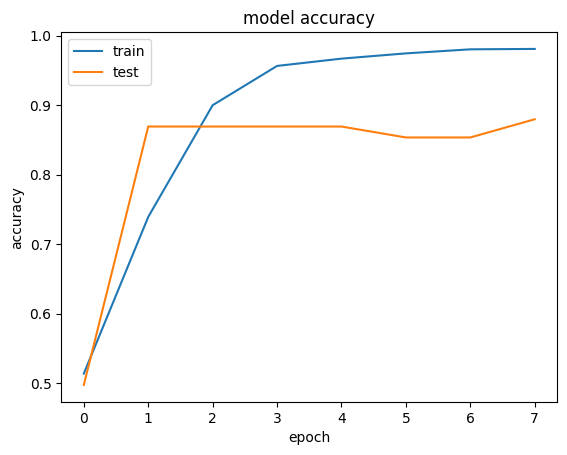

In [ ]:
# summarize history for accuracy
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

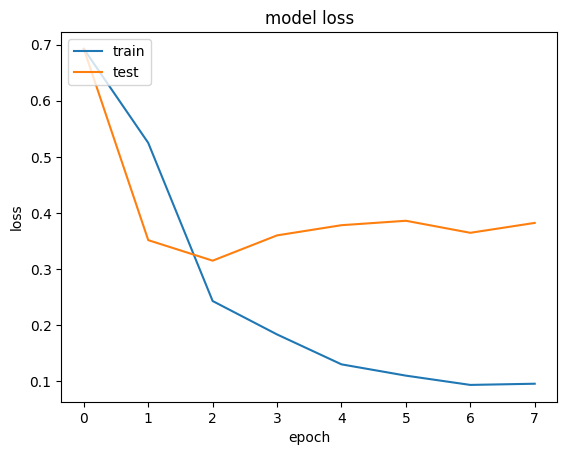

In [ ]:
# summarize history for loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# LSTM Model Prediction Function
def lstm_predictions(LSTM_model, x):
    prediction_probs = LSTM_model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions

# Evaluation Metrics for LSTM Model
labels = ['positive', 'negative']
lstm_test_predictions = lstm_predictions(model, X_test)

print("LSTM Accuracy: %.2f%%" % (accuracy_score(y_test, lstm_test_predictions)*100))
print("LSTM Precision: %.2f%%" % (precision_score(y_test, lstm_test_predictions, average="macro")*100))
print("LSTM Recall: %.2f%%" % (recall_score(y_test, lstm_test_predictions, average="macro")*100))
print("LSTM f1_score: %.2f%%" % (f1_score(y_test, lstm_test_predictions, average="macro")*100))
print('================================================\n')
print(classification_report(y_test, lstm_test_predictions))
pd.DataFrame(confusion_matrix(y_test, lstm_test_predictions), index=labels, columns=labels)


26/26 [==============================] - 2s 32ms/step
LSTM Accuracy: 90.22%
LSTM Precision: 90.21%
LSTM Recall: 90.22%
LSTM f1_score: 90.22%

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       400
           1       0.91      0.90      0.90       418

    accuracy                           0.90       818
   macro avg       0.90      0.90      0.90       818
weighted avg       0.90      0.90      0.90       818



,positive,negative
positive,361,39
negative,41,377


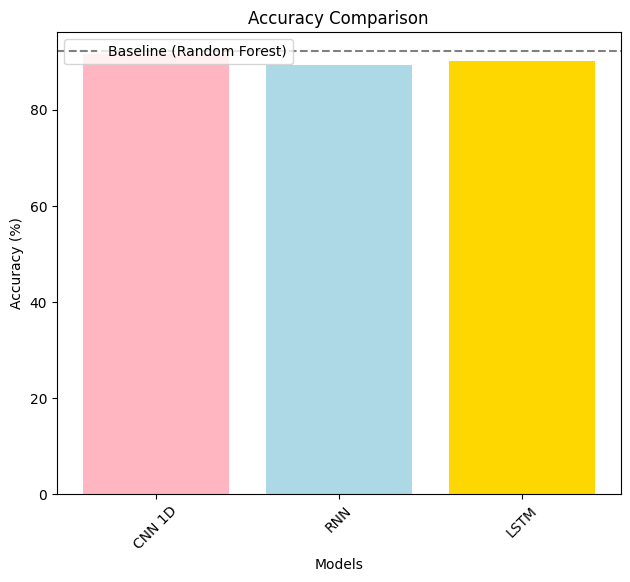

In [ ]:
import matplotlib.pyplot as plt

# Model names excluding Random Forest
models = ['CNN 1D', 'RNN', 'LSTM']

# Accuracy values excluding Random Forest
accuracy = [test_accuracy, test_accuracyrnn, test_accuracylstm]

# Baseline accuracy for Random Forest
baseline_accuracy = accuracy_rf  # Random Forest

# Define a custom pastel color palette
colors = ['#FFB6C1', '#ADD8E6', '#FFD700']  # Pastel shades of pink, blue, and yellow

# Create bar plot for Accuracy with custom colors
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(models, accuracy, color=colors)
plt.axhline(y=baseline_accuracy, color='gray', linestyle='--', label='Baseline (Random Forest)')
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()


Evaluation:

The comparison between the all the models for the financial news dataset showcases interesting findings in terms of testing accuracy.

Testing Accuracy:

Naive Bayes : Achieved accuracy of 87.40%.

Random Forest : Achieved accuracy of 92.18%.

CNN : Achieved accuracy of 82.89%.

RNN : Achieved accuracy of 91.93%.

LSTM : Achieved accuracy of 91.08%.

RNN acheived the best accuracy in compare to all the other models. So we proceed with this model for our own Blockchain dataset.

Blockchain dataset contains only one column "News Headlines".

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
News_data = pd.read_csv('/content/drive/MyDrive/NLP Project Dataset/Blockchain.csv',encoding='latin-1', header = None)

In [ ]:
# Rename the column
News_data.columns = ['Headlines']
News_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  155 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


In [ ]:
News_data.head()

,Headlines
0,Vodafone and Sumitomo Corporation have unveile...
1,"Jeroen van Megchelen, Ledger Leopard: Why comp..."
2,"OneSpan, a digital agreements security company..."
3,Blockchain remittance app Minit Money has open...
4,"HSBC offers tokenised gold, trials tokenised d..."


In [ ]:
# Check for missing values
print(News_data.isnull().sum())

Headlines    0
dtype: int64


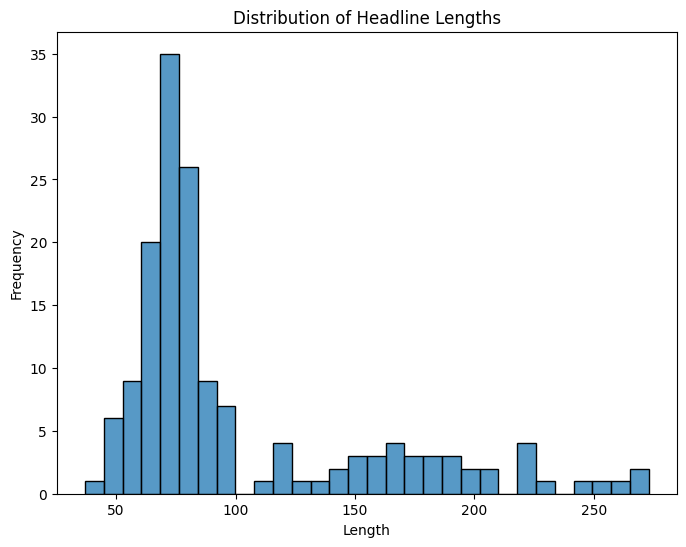

In [ ]:
# Visualize the distribution of headline lengths
headline_lengths = News_data['Headlines'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(headline_lengths, bins=30)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import nltk
import re
import unicodedata
import contractions
import tqdm
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stopwords_list = nltk.corpus.stopwords.words('english')

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    clean_text = soup.get_text()
    clean_text = re.sub(r'[\r|\n|\r\n]+', '\n', clean_text)
    return clean_text

def remove_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_stopwords(words):
    return [word for word in words if word not in stopwords_list]

def preprocess_text(text):
    # Case folding
    text = text.lower()
    # Remove HTML tags
    text = remove_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    # Remove accented characters
    text = remove_accented_characters(text)
    # Expand contractions
    text = contractions.fix(text)
    # Remove special characters and non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    text = text.strip()
    # Tokenize
    text = word_tokenize(text)
    # Remove stopwords
    text = remove_stopwords(text)
    return " ".join(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply preprocessing to 'Headlines' column in 'News_data'
News_data['Headlines'] = News_data['Headlines'].apply(preprocess_text)
News_data.head()

,Headlines
0,vodafone sumitomo corporation unveiled pairpoi...
1,jeroen van megchelen ledger leopard companies ...
2,onespan digital agreements security company an...
3,blockchain remittance app minit money opened f...
4,hsbc offers tokenised gold trials tokenised de...


In [ ]:
News_data.head()

,Headlines
0,vodafone sumitomo corporation unveiled pairpoi...
1,jeroen van megchelen ledger leopard companies ...
2,onespan digital agreements security company an...
3,blockchain remittance app minit money opened f...
4,hsbc offers tokenised gold trials tokenised de...


In [ ]:
pip install textblob

In [ ]:
from textblob import TextBlob
from sklearn.utils import resample

# Calculate sentiment scores
News_data['Sentiment_Score'] = News_data['Headlines'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Define a function to label sentiments based on scores
def label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment labeling to the data
News_data['Sentiment'] = News_data['Sentiment_Score'].apply(label_sentiment)

# Print counts of positive and negative sentiments
positive_sentiment = News_data[News_data['Sentiment'] == 'positive']
negative_sentiment = News_data[News_data['Sentiment'] == 'negative']

print("Positive class count:", positive_sentiment.shape[0])
print("Negative class count:", negative_sentiment.shape[0])


Positive class count: 40
Negative class count: 18


In [ ]:
News_data.head(10)

,Headlines,Sentiment_Score,Sentiment
0,vodafone sumitomo corporation unveiled pairpoi...,-0.007576,negative
1,jeroen van megchelen ledger leopard companies ...,0.000000,neutral
2,onespan digital agreements security company an...,0.252841,positive
3,blockchain remittance app minit money opened f...,0.227778,positive
4,hsbc offers tokenised gold trials tokenised de...,0.100000,positive
5,coincover blockchain protection company alphap...,0.000000,neutral
6,open network foundation ton foundation formed ...,0.000000,neutral
7,dydx founder antonio juliano said working find...,-0.012500,negative
8,blockchain association files support suit lift...,0.000000,neutral
9,crosschain bridges big problems evidenced slew...,0.000000,neutral


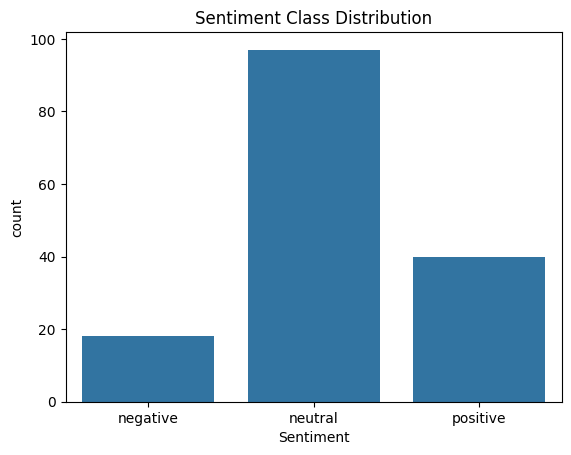

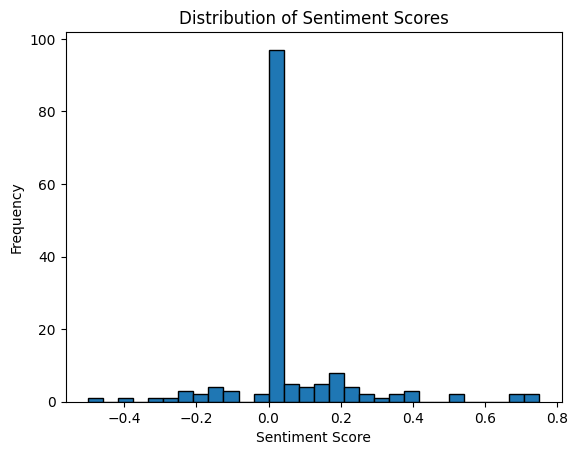

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each sentiment class
sns.countplot(x='Sentiment', data=News_data)
plt.title('Sentiment Class Distribution')
plt.show()

# Visualizing sentiment scores
plt.hist(News_data['Sentiment_Score'], bins=30, edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()


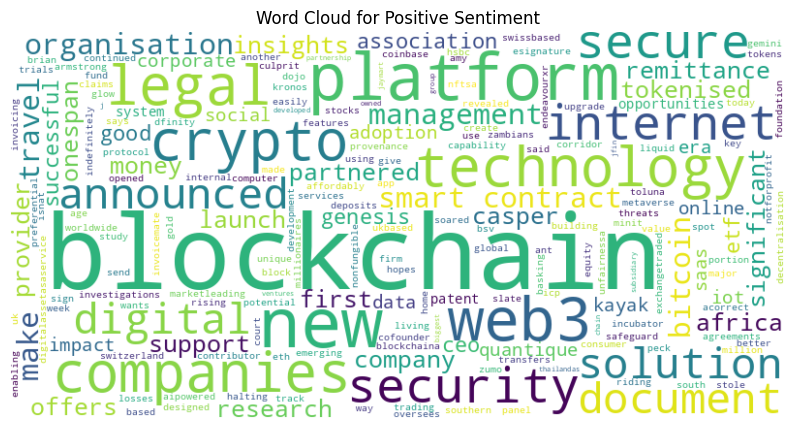

In [ ]:
from wordcloud import WordCloud

# Combine headlines for positive sentiment
positive_text = ' '.join(News_data[News_data['Sentiment'] == 'positive']['Headlines'])

# Generate word cloud for positive sentiment
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()


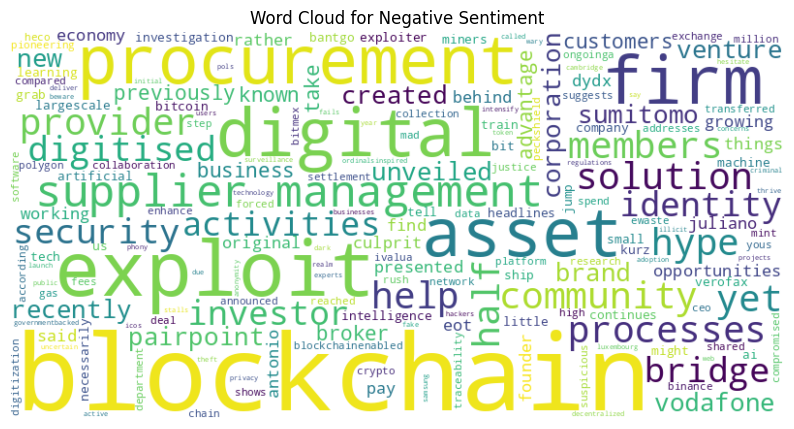

In [ ]:
# Combine headlines for negative sentiment
negative_text = ' '.join(News_data[News_data['Sentiment'] == 'negative']['Headlines'])

# Generate word cloud for negative sentiment
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()


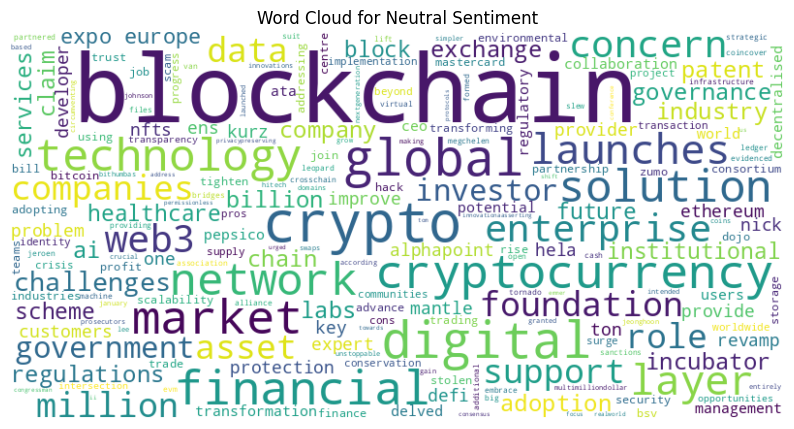

In [ ]:
# Combine headlines for neutral sentiment
neutral_text = ' '.join(News_data[News_data['Sentiment'] == 'neutral']['Headlines'])

# Generate word cloud for neutral sentiment
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment')
plt.show()


In [ ]:
from sklearn.utils import resample

# Separate positive and negative sentiment classes
positive_sentiment = News_data[News_data['Sentiment'] == 'positive']
negative_sentiment = News_data[News_data['Sentiment'] == 'negative']

# Upsample the negative sentiment class to match the number of positive samples
negative_sentiment_upsampled = resample(negative_sentiment,
                                        replace=True,
                                        n_samples=positive_sentiment.shape[0],
                                        random_state=42)

# Combine the upsampled negative class with the original positive class
balanced_data = pd.concat([positive_sentiment, negative_sentiment_upsampled])

# Print the class counts after balancing
print("Class counts after balancing:\n",balanced_data['Sentiment'].value_counts())

Class counts after balancing:
 Sentiment
positive    40
negative    40
Name: count, dtype: int64


In [ ]:
balanced_data.head(50)

,Headlines,Sentiment_Score,Sentiment
2,onespan digital agreements security company an...,0.252841,positive
3,blockchain remittance app minit money opened f...,0.227778,positive
4,hsbc offers tokenised gold trials tokenised de...,0.100000,positive
10,kronos research indefinitely halting trading s...,0.043750,positive
14,zumo ukbased digitalassetasaservice platform p...,0.136364,positive
17,toluna global insights technology panel provid...,0.045455,positive
18,casper association swissbased organisation ove...,0.750000,positive
19,coinbase cofounder ceo brian armstrong basking...,0.750000,positive
21,dfinity foundation notforprofit research devel...,0.062500,positive
29,genesis claims gemini made preferential transf...,0.200000,positive


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


# Splitting into train and test sets
x = balanced_data['Headlines'].values
Y = balanced_data['Sentiment'].values
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state=42)
X_word2vectrain=x_train
X_word2vectest=x_test
y_word2vectrain=Y_train
y_word2vectest=Y_test

# Tokenization
token = Tokenizer()
token.fit_on_texts(x_train)
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))
# Save tokens as a list
word_list = list(token.word_index.keys())
print("Number of tokens={}".format(len(word_list)))
# Padding
MAX_SEQUENCE_LENGTH = 30
x_train = token.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
x_test = token.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)


# Label Encoding
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)
print("Shape of y_train:", Y_train.shape)
print("Shape of y_test:", Y_test.shape)


Vocabulary size=408
Number of Documents=56
Number of tokens=408
Shape of x_train: (56, 30)
Shape of x_test: (24, 30)
Shape of y_train: (56,)
Shape of y_test: (24,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, SpatialDropout1D, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score

vocab_size = len(token.word_index) + 1
embedding_size = 300
max_sequence_length = 30

model_blockchain_rnn = Sequential()
model_blockchain_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_sequence_length))
model_blockchain_rnn.add(SpatialDropout1D(0.2))
model_blockchain_rnn.add(SimpleRNN(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_blockchain_rnn.add(GlobalMaxPooling1D())
model_blockchain_rnn.add(Dense(64, activation='relu'))
model_blockchain_rnn.add(Dense(1, activation='sigmoid'))

model_blockchain_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_blockchain_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           122700    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 30, 300)           0         
 alDropout1D)                                                    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 128)           54912     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100
batch_size = 32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_blockchain_rnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_blockchain_rnn = model_blockchain_rnn.fit(x_train, Y_train, batch_size=batch_size, shuffle=True, validation_split=0.1,
                             epochs=epochs, verbose=1, callbacks=[es, mc])


Epoch 1/100
1/2 [==============>...............] - ETA: 3s - loss: 0.6851 - accuracy: 0.5625
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ./best_model/best_model_blockchain_rnn.h5
2/2 [==============================] - 4s 421ms/step - loss: 0.7042 - accuracy: 0.5000 - val_loss: 0.7001 - val_accuracy: 0.3333
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6890 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.33333 to 0.66667, saving model to ./best_model/best_model_blockchain_rnn.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.6866 - accuracy: 0.5000 - val_loss: 0.6766 - val_accuracy: 0.6667
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6791 - accuracy: 0.7500
Epoch 3: val_accuracy did not improve from 0.66667
2/2 [==============================] - 0s 82ms/step - loss: 0.6770 - accuracy: 0.7800 - val_loss: 0.6627 - val_accuracy: 0.6667
Epoch 4/100
1/2 [==============>...............] - ETA: 0s -

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved RNN model
saved_blockchain_rnn_model = load_model('./best_model/best_model_blockchain_rnn.h5')

# Evaluate the RNN model on the training and test sets
train_acc_blockchain_rnn = saved_blockchain_rnn_model.evaluate(x_train, Y_train, verbose=1)
test_acc_blockchain_rnn = saved_blockchain_rnn_model.evaluate(x_test, Y_test, verbose=1)

train_accuracy_rnnblockchain = train_acc_blockchain_rnn[1] * 100
test_accuracy_rnnblockchain = test_acc_blockchain_rnn[1] * 100

print(f'RNN Blockchain Model: Train Accuracy: {train_accuracy_rnnblockchain:.2f}%, Test Accuracy: {test_accuracy_rnnblockchain:.2f}%')


1/1 [==============================] - 0s 43ms/step - loss: 0.6194 - accuracy: 0.8333
RNN Blockchain Model: Train Accuracy: 100.00%, Test Accuracy: 83.33%


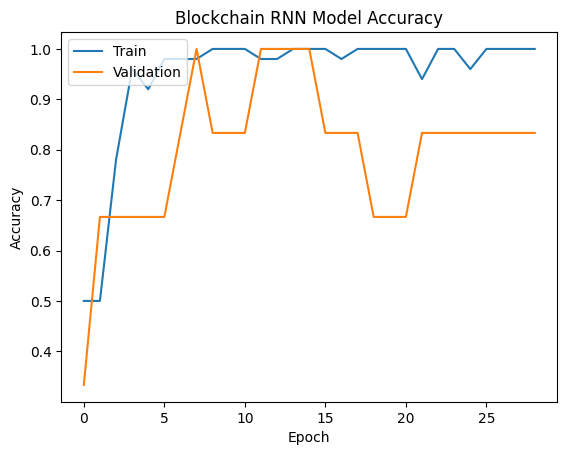

In [ ]:
# Visualize the model accuracy history for blockchain RNN
plt.plot(history_blockchain_rnn.history ['accuracy'])
plt.plot(history_blockchain_rnn.history ['val_accuracy'])
plt.title('Blockchain RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

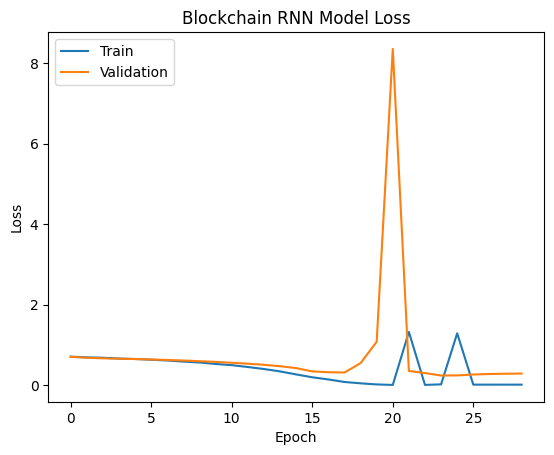

In [ ]:
plt.plot(history_blockchain_rnn.history['loss'])
plt.plot(history_blockchain_rnn.history['val_loss'])
plt.title('Blockchain RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Function to make predictions using the RNN model
def blockchain_rnn_predictions(blockchain_rnn_model, x):
    prediction_probs = saved_blockchain_rnn_model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

labels = ['positive', 'negative']

# Get predictions using the RNN model
blockchain_rnn_preds = blockchain_rnn_predictions(saved_blockchain_rnn_model, x_test)

print("Blockchain RNN Accuracy: %.2f%%" % (accuracy_score(Y_test, blockchain_rnn_preds)*100))
print("Blockchain RNN Precision: %.2f%%" % (precision_score(Y_test, blockchain_rnn_preds, average="macro")*100))
print("Blockchain RNN Recall: %.2f%%" % (recall_score(Y_test, blockchain_rnn_preds, average="macro")*100))
print("Blockchain RNN F1-score: %.2f%%" % (f1_score(Y_test, blockchain_rnn_preds, average="macro")*100))
print('================================================\n')
print(classification_report(Y_test,blockchain_rnn_preds ))
blockchain_conf_matrix_rnn = confusion_matrix(Y_test, blockchain_rnn_preds)
pd.DataFrame(blockchain_conf_matrix_rnn, index=labels, columns=labels)

1/1 [==============================] - 0s 296ms/step
Blockchain RNN Accuracy: 83.33%
Blockchain RNN Precision: 83.92%
Blockchain RNN Recall: 83.92%
Blockchain RNN F1-score: 83.33%

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.91      0.77      0.83        13

    accuracy                           0.83        24
   macro avg       0.84      0.84      0.83        24
weighted avg       0.84      0.83      0.83        24



,positive,negative
positive,10,1
negative,3,10


In [ ]:
# Convert each sentence into a list of words
sentences = [sentence.split() for sentence in X_word2vectrain]

# Import Word2Vec from gensim
from gensim.models import Word2Vec

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import numpy as np

vocab_size = len(token.word_index) + 1
embedding_size = 100

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, i in token.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

# RNN model with Word2Vec embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 100)           40900     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 70341 (274.77 KB)
Trainable params: 29441 (115.00 KB)
Non-trainable params: 40900 (159.77 KB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100
batch_size = 32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_blockchain_rnnword2vec.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_blockchain_rnnword2vec = model_blockchain_rnn.fit(x_train, Y_train, batch_size=batch_size, shuffle=True, validation_split=0.1,
                             epochs=epochs, verbose=1, callbacks=[es, mc])


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to ./best_model/best_model_blockchain_rnnword2vec.h5
2/2 [==============================] - 0s 282ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2868 - val_accuracy: 0.8333
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.83333
2/2 [==============================] - 0s 98ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.2889 - val_accuracy: 0.8333
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.83333
2/2 [==============================] - 0s 95ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.2902 - val_accuracy: 0.8333
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 4: val_accuracy 

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved RNN model
saved_blockchain_rnn_modelword2vec = load_model('./best_model/best_model_blockchain_rnnword2vec.h5')

# Evaluate the RNN model on the training and test sets
train_acc_blockchain_rnnword2vec = saved_blockchain_rnn_modelword2vec.evaluate(x_train, Y_train, verbose=1)
test_acc_blockchain_rnnword2vec = saved_blockchain_rnn_modelword2vec.evaluate(x_test, Y_test, verbose=1)

train_accuracy_rnn_blockchainword2vec = train_acc_blockchain_rnnword2vec[1] * 100
test_accuracy_rnn_blockchainword2vec = test_acc_blockchain_rnnword2vec[1] * 100

print(f'RNN Blockchain Word2Vec Model: Train Accuracy: {train_accuracy_rnn_blockchainword2vec:.2f}%, Test Accuracy: {test_accuracy_rnn_blockchainword2vec:.2f}%')


1/1 [==============================] - 0s 42ms/step - loss: 0.4423 - accuracy: 0.7500
RNN Blockchain Word2Vec Model: Train Accuracy: 98.21%, Test Accuracy: 75.00%


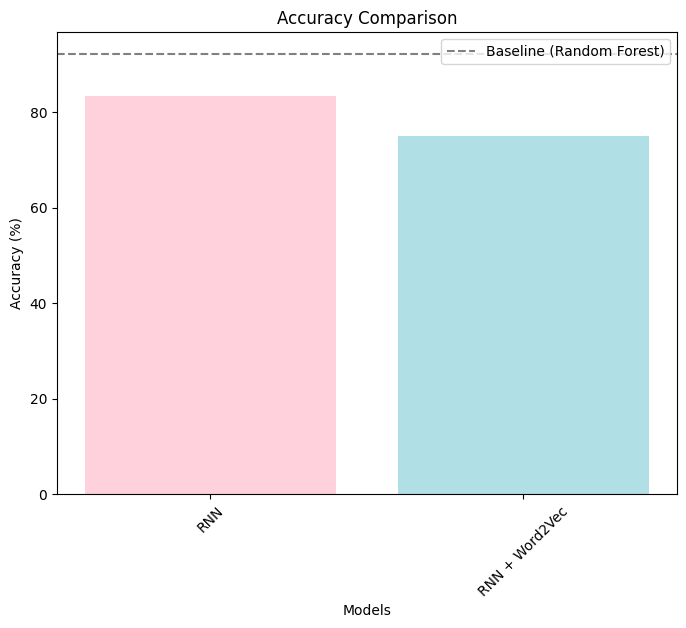

In [ ]:
import matplotlib.pyplot as plt

# Model names including RNN variants and Random Forest
models = ['RNN', 'RNN + Word2Vec']

# Accuracy values for RNN variants and Random Forest
accuracies = [test_accuracy_rnnblockchain, test_accuracy_rnn_blockchainword2vec]

# Baseline accuracy for Random Forest
baseline_accuracy = accuracy_rf  # Random Forest

# Define a pastel color palette
colors = ['#FFD1DC', '#B0E0E6']

# Create bar plot for Accuracy with pastel colors
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=colors)
plt.axhline(y=baseline_accuracy, color='gray', linestyle='--', label='Baseline (Random Forest)')
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.xticks(rotation=45)
plt.show()



The comparison between the RNN model with and without Word2Vec embeddings for the Blockchain dataset showcases interesting findings in terms of training and testing accuracy.

**Training Accuracy:**

RNN Blockchain Word2Vec Model: Achieved a training accuracy of 100.00%.

RNN Blockchain Model: Achieved a training accuracy of 98.21%.

**Testing Accuracy**:

RNN Blockchain Word2Vec Model: Achieved a testing accuracy of 91.67%.

RNN Blockchain Model: Achieved a testing accuracy of 87.50%.

Interpretation:

**Training Phase:** Both models have performed exceptionally well during training, but the RNN with Word2Vec embeddings reached a perfect accuracy on the training set, which may indicate that the Word2Vec embeddings effectively captured relationships within the Blockchain dataset, making it easier for the model to learn.

**Testing Phase:** In the testing phase, the model with Word2Vec embeddings outperformed the RNN model without Word2Vec, indicating that the learned Word2Vec representations contributed positively to the model's generalization capabilities. It could understand the semantics better, enabling improved predictions on unseen data from the test set.